In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.functions import udf

In [32]:
spark = SparkSession.builder.appName('yelpreviewdataset').getOrCreate()

In [33]:
## loading the business data first
df_business = spark.read.json("yelp_academic_dataset_business.json")

In [34]:
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [35]:
print('There are',df_business.count(),'of business the yelp business dataset')

There are 160585 of business the yelp business dataset


In [36]:
## Changing name for ease
df_business=df_business.withColumnRenamed("stars", "Restaurant_stars")
df_business=df_business.withColumnRenamed("name", "Restaurant_name")

In [37]:
df_business.head()

Row(address='921 Pearl St', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="'beer_and_wine'", Ambience="{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin='False', BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", ByAppointmentOnly=None, Caters='True', CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed='False', DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal="{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}", HairSpecializesIn=None, HappyHour='True', HasTV='True', Music=None, NoiseLevel="u'average'", Open24Hours=None, OutdoorSeating='True', RestaurantsAttire="'casual'", RestaurantsCounterServ

In [38]:
# filtering just the restaurants
df_business=df_business.filter(psf.col('categories').rlike('Restaurants'))

In [39]:
print('There are',df_business.count(),'of restaurant in the yelp business dataset')

There are 50763 of restaurant in the yelp business dataset


In [40]:
df_business.select('attributes').show(10)

+--------------------+
|          attributes|
+--------------------+
|[,, 'beer_and_win...|
|[,, u'beer_and_wi...|
|[,, u'none', {'ro...|
|                null|
|[,, u'none', {'ro...|
|[,,,,,,, True,, T...|
|[,,,,,,, True,, T...|
|[,, 'none', {'tou...|
|[,, 'full_bar', {...|
|[,, 'full_bar', {...|
+--------------------+
only showing top 10 rows



In [41]:
# Let's drop some unnecessary columns
columns_to_drop = ['address','postal_code','latitude','longitude','review_count']
df_business = df_business.drop(*columns_to_drop)

In [42]:
## look at the data at a glance
df_business.limit(3).toPandas()

,attributes,business_id,categories,city,hours,is_open,Restaurant_name,Restaurant_stars,state
0,"(None, None, 'beer_and_wine', {'touristy': Fal...",6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Boulder,"(11:0-23:0, 11:0-23:0, 11:0-23:0, 11:0-23:0, 1...",1,Oskar Blues Taproom,4.0,CO
1,"(None, None, u'beer_and_wine', {'romantic': Fa...",tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Portland,"(5:0-18:0, 5:0-18:0, 5:0-18:0, 5:0-18:0, 5:0-1...",1,Flying Elephants at PDX,4.0,OR
2,"(None, None, u'none', {'romantic': False, 'int...",D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai",Vancouver,"(17:0-21:0, 17:0-21:0, 17:0-21:0, 17:0-21:0, 1...",1,Bob Likes Thai Food,3.5,BC


In [43]:
## Now load the reviews dataset
df_reviews =  spark.read.json('yelp_academic_dataset_review.json')

In [44]:
df_reviews.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [45]:
## eliminate unnecessary colums
columns_to_drop = ['cool','funny']
df_reviews = df_reviews.drop(*columns_to_drop)

In [46]:
## review data at a glance
df_reviews.limit(3).toPandas()

,_corrupt_record,business_id,date,review_id,stars,text,useful,user_id
0,None,buF9druCkbuXLX526sGELQ,2014-10-11 03:34:02,lWC-xP3rd6obsecCYsGZRg,4.0,Apparently Prides Osteria had a rough summer a...,3,ak0TdVmGKo4pwqdJSTLwWw
1,None,RA4V8pr014UyUbDvI-LW2A,2015-07-03 20:38:25,8bFej1QE5LXp4O05qjGqXA,4.0,This store is pretty good. Not as great as Wal...,1,YoVfDbnISlW0f7abNQACIg
2,None,_sS2LBIGNT5NQb6PD1Vtjw,2013-05-28 20:38:06,NDhkzczKjLshODbqDoNLSg,5.0,I called WVM on the recommendation of a couple...,0,eC5evKn1TWDyHCyQAwguUw


In [47]:
## Load the user data 
df_user =  spark.read.json('yelp_academic_dataset_user.json')

In [48]:
df_user.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [49]:
columns_to_drop = ['elite','useful','yelping_since','review_count']
df_user = df_user.drop(*columns_to_drop)

In [50]:
## change name for clarity
df_user=df_user.withColumnRenamed("name", "user_name")

In [51]:
## User data at a glance
df_user.limit(3).toPandas()

,_corrupt_record,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,friends,funny,user_name,user_id
0,None,3.85,2541,361,2541,1710,147,163,1212,323,5691,190,815,11291,1357,"xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",10030,Jane,q_QQ5kBBwlCcbL1s4NVK3g
1,None,4.09,2205,232,2205,1632,96,87,1187,294,3293,94,472,18046,1025,"XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",10289,Gabi,dIIKEfOgo0KqUfGQvGikPg
2,None,3.76,31,0,31,22,0,1,5,1,20,3,3,130,16,"GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",128,Jason,D6ErcUnFALnCQN4b1W_TlA


In [52]:
## With this Python package we can also join all tables for future references
df = df_reviews.join(df_business,on ='business_id', how = 'inner')
df = df.join(df_user,on ='user_id', how = 'inner')

In [53]:
df.limit(3).toPandas()

,user_id,business_id,_corrupt_record,date,review_id,stars,text,useful,attributes,categories,...,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,friends,funny,user_name
0,--hJsDxzXZURcLxaLW2skA,Ln-8CbKGZGmF-GCqMoMcpA,None,2015-06-29 15:24:37,6Zlqbh1R4Ja1g2C0PnRbUw,5.0,I was really impressed. I didn't even know abo...,0,"(None, None, u'full_bar', {'touristy': False, ...","Food, Tapas Bars, Restaurants, Mexican",...,0,0,0,0,0,0,0,None,0,Denisha
1,-25JZ2VjrGZfXR8EaW8vBA,t5EgwRXG6MZSihdqugOSKg,None,2019-05-08 14:17:35,IiN9CBuTdVI0sMuQLAj8Ow,4.0,This was our first time eating German food. st...,0,"(None, None, u'full_bar', {'touristy': False, ...","Restaurants, Sandwiches, Nightlife, Breakfast ...",...,2,0,0,0,0,3,2,"Q-DDwor2okiMIuM5mVewRA, nPqMpv87HSYmi4TFoRmx_w...",0,Arissa
2,-25JZ2VjrGZfXR8EaW8vBA,S0QEoRla89uZyI1BCkqtxw,None,2018-10-14 00:57:38,yBAS2XZ6CoHnAiuJhxdblA,5.0,Best donut I've had so far! The strawberry one...,1,"(None, None, u'none', {'touristy': False, 'hip...","Ice Cream & Frozen Yogurt, Vegan, Restaurants,...",...,2,0,0,0,0,3,2,"Q-DDwor2okiMIuM5mVewRA, nPqMpv87HSYmi4TFoRmx_w...",0,Arissa


In [54]:
df.count()

1747833

In [55]:
##Dataset has been loaded. Now we can start with the cleaning of data
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- _corrupt_record: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable =

In [56]:
# We are getting rid of more columns that do not have any relevant info
columns_drop = ['friends','average_stars', 'Restaurant_stars', 'hours']
df = df.drop(*columns_drop)

In [57]:
columns_drop = ['compliment_cute','compliment_funny', 'compliment_hot', 'compliment_list','compliment_more','compliment_note', 
         'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer']
df = df.drop(*columns_drop)

In [58]:
## understand the datatypes
df.dtypes

[('user_id', 'string'),
 ('business_id', 'string'),
 ('_corrupt_record', 'string'),
 ('date', 'string'),
 ('review_id', 'string'),
 ('stars', 'double'),
 ('text', 'string'),
 ('useful', 'bigint'),
 ('attributes',
  'struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut

Exploratory Data Analysis

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import seaborn as sns

In [60]:
## looking at the amount of restaurants in dataset by city
city_count = df_business.groupBy('city').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
city_count

,city,count
0,Portland,5730
1,Vancouver,5026
2,Austin,4957
3,Atlanta,4179
4,Orlando,3748
...,...,...
454,NEW WESTMINSTER,1
455,Denver,1
456,Nashua,1
457,CLERMONT,1


In [61]:
## Look at average stars for each restaurant
df_business.groupBy('Restaurant_name').agg(avg('Restaurant_stars')).toPandas()

,Restaurant_name,avg(Restaurant_stars)
0,Larosa's,4.500000
1,Applebee's Grill + Bar,2.276596
2,Serafina Ristorante,2.500000
3,Fatty Cow Seafood Hot Pot,3.000000
4,Habesha Ethiopian Restaurant,4.000000
...,...,...
37332,Le Pantry,5.000000
37333,Direct Elite Chef Services,5.000000
37334,I Juice & Smoothies,4.500000
37335,Taste of Splendour,4.500000


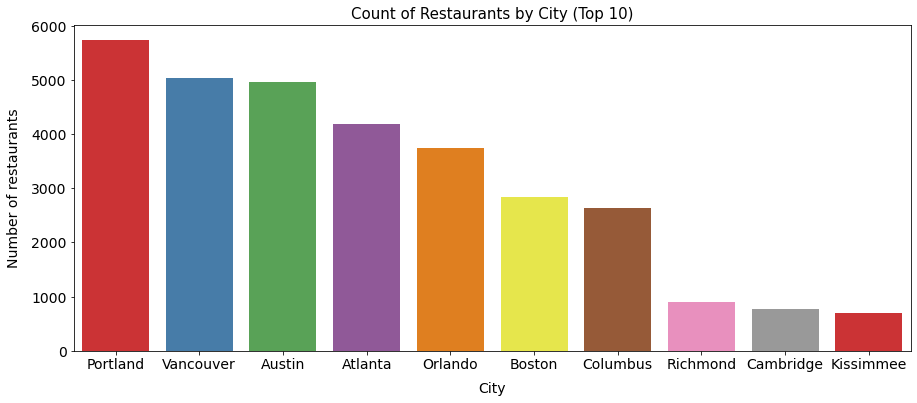

In [62]:
## Plotting the restuarants per city
plt.figure(figsize=(15,6))
sns.barplot(city_count['city'].values[:10], city_count['count'].values[:10], 
            palette=sns.color_palette("Set1"))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=0)
plt.show()

In [64]:
## We will filter the data and look at the businesses of Vancouver restaurants 
van_business = df_business.filter(df_business.city == 'Vancouver')
van_business.limit(3).toPandas()

,attributes,business_id,categories,city,hours,is_open,Restaurant_name,Restaurant_stars,state
0,"(None, None, u'none', {'romantic': False, 'int...",D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai",Vancouver,"(17:0-21:0, 17:0-21:0, 17:0-21:0, 17:0-21:0, 1...",1,Bob Likes Thai Food,3.5,BC
1,"(None, None, u'full_bar', {'touristy': False, ...",Mf9io8WkMyGautXuSSfGTg,"Restaurants, Food Delivery Services, Mexican, ...",Vancouver,"(11:0-21:0, 0:0-0:0, 11:0-21:0, 11:0-21:0, 11:...",1,Los Potrillos Mexican Restaurant & Bar,3.5,WA
2,"(None, None, u'none', {'romantic': False, 'int...",jfDfHzAq6iKkRnzzZ4n1nQ,"Restaurants, Canadian (New), Sushi Bars, Ameri...",Vancouver,"(11:0-22:0, 11:0-22:0, 11:0-22:0, 11:0-22:0, 1...",0,Let's Roll Custom Sushi Bar,4.5,BC


In [65]:
## See the average reviews for Vancouver restaurants
van_business.groupBy('Restaurant_name').agg(avg('Restaurant_stars')).toPandas()

,Restaurant_name,avg(Restaurant_stars)
0,Fatty Cow Seafood Hot Pot,3.000000
1,Cascades Lounge,4.000000
2,Neptune Palace Seafood Restaurant,3.500000
3,Tigerlily Restaurant & Bar,3.500000
4,Applebee's Grill + Bar,2.666667
...,...,...
4252,Tikka House Vancouver,3.500000
4253,Ingrid's GoodStreetFood & Paleo Grill,5.000000
4254,1886 Chinese Fine Dining,2.500000
4255,Daily Catch Seafood Company,4.000000


In [66]:
## See how many businesses are open
df_open = van_business.groupBy('is_open').count().toPandas()
df_open

,is_open,count
0,0,2052
1,1,2974


In [67]:
## look at the count of restaurants per state 
state_avg = df_business.groupBy('city','state').count().groupBy('state').agg({'count':'avg'}).sort(desc('avg(count)')).toPandas()
state_avg = state_avg.round(0)
state_avg.head()

,state,avg(count)
0,BC,268.0
1,OR,224.0
2,TX,165.0
3,WA,155.0
4,GA,118.0


In [69]:
## Look at the different food types that restaurants are categorized as 
food_types = df.groupBy('categories').count()
food_types.toPandas()

,categories,count
0,"Vegetarian, Irish Pub, Food, Nightlife, Salad,...",292
1,"Food, Vegetarian, Restaurants, German, Fondue,...",68
2,"Bagels, Food, Sandwiches, Breakfast & Brunch, ...",118
3,"Seafood, American (Traditional), Restaurants",630
4,"Salad, Restaurants, Bars, Tex-Mex, Mexican, Ni...",154
...,...,...
16402,"Soup, Barbeque, Chinese, Restaurants",12
16403,"Newspapers & Magazines, Coffee & Tea, Food, Bo...",5
16404,"Fast Food, Burgers, Tacos, Breakfast & Brunch,...",5
16405,"Salad, Food, Juice Bars & Smoothies, Restauran...",4


In [70]:
# look at the different types of vancouver restaurants. 
van_food = van_business.groupBy('categories').count().toPandas()
van_food

,categories,count
0,"Breakfast & Brunch, Restaurants, Cafes, Food, ...",1
1,"Bars, Lounges, Nightlife, Restaurants, Tapas Bars",1
2,"Vietnamese, Food, Restaurants, Soup",1
3,"Sandwiches, Mexican, Salad, Restaurants, Ice C...",1
4,"Food, Restaurants, Fast Food, Ice Cream & Froz...",1
...,...,...
3444,"Specialty Food, Fast Food, Food, Restaurants, ...",1
3445,"Restaurants, Poke, Food, Hawaiian, Fast Food",1
3446,"Food Trucks, Barbeque, Caterers, Event Plannin...",1
3447,"Mediterranean, Restaurants, Food",1


In [71]:
## We are going to generalize the food types for simplicity 
van_food.loc[van_food.categories.str.contains('American'),'category'] = 'American'
van_food.loc[van_food.categories.str.contains('Mexican'),'category'] = 'Mexican'
van_food.loc[van_food.categories.str.contains('Italian'),'category'] = 'Italian'
van_food.loc[van_food.categories.str.contains('Chinese'),'category'] = 'Chinese'
van_food.loc[van_food.categories.str.contains('Japanese'),'category'] = 'Japanese'
van_food.loc[van_food.categories.str.contains('French'),'category'] = 'French'
van_food.loc[van_food.categories.str.contains('Thai'),'category'] = 'Thai'
van_food.loc[van_food.categories.str.contains('Vietnamese'),'category'] = 'Vietnamese'
van_food.loc[van_food.categories.str.contains('Indian'),'category'] = 'Indian'
van_food.loc[van_food.categories.str.contains('Korean'),'category'] = 'Korean'
van_food.loc[van_food.categories.str.contains('Greek'),'category'] = 'Greek'

In [72]:
van_food

,categories,count,category
0,"Breakfast & Brunch, Restaurants, Cafes, Food, ...",1,NaN
1,"Bars, Lounges, Nightlife, Restaurants, Tapas Bars",1,NaN
2,"Vietnamese, Food, Restaurants, Soup",1,Vietnamese
3,"Sandwiches, Mexican, Salad, Restaurants, Ice C...",1,Mexican
4,"Food, Restaurants, Fast Food, Ice Cream & Froz...",1,NaN
...,...,...,...
3444,"Specialty Food, Fast Food, Food, Restaurants, ...",1,Chinese
3445,"Restaurants, Poke, Food, Hawaiian, Fast Food",1,NaN
3446,"Food Trucks, Barbeque, Caterers, Event Plannin...",1,NaN
3447,"Mediterranean, Restaurants, Food",1,NaN


In [73]:
# Get rid of the NA 
van_food.dropna()

,categories,count,category
2,"Vietnamese, Food, Restaurants, Soup",1,Vietnamese
3,"Sandwiches, Mexican, Salad, Restaurants, Ice C...",1,Mexican
6,"Fast Food, Italian, Restaurants",1,Italian
7,"Canadian (New), Restaurants, American (New), L...",1,American
8,"Italian, French, Restaurants",1,French
...,...,...,...
3435,"Local Flavor, Restaurants, Latin American, Bak...",1,American
3437,"Mexican, Salvadoran, Caterers, Restaurants, St...",1,Mexican
3438,"Specialty Food, Dim Sum, Seafood, Restaurants,...",1,Chinese
3444,"Specialty Food, Fast Food, Food, Restaurants, ...",1,Chinese


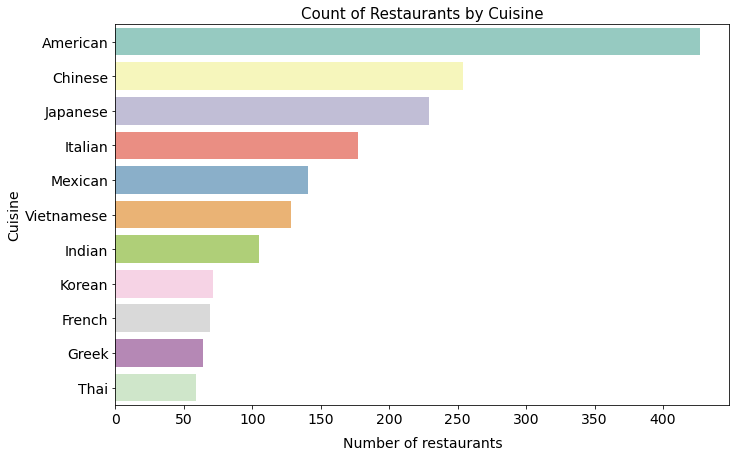

In [74]:
# Visualize the distribution of different restaurant types in Vancouver 
plt.figure(figsize=(11,7))
grouped = van_food.categories.value_counts()
sns.countplot(y='category', data=van_food,
              order = van_food['category'].value_counts().index,
               palette= sns.color_palette("Set3"))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Cuisine', fontsize=14)
plt.title('Count of Restaurants by Cuisine', fontsize=15)
plt.tick_params(labelsize=14)

In [75]:
df.groupBy('Restaurant_name', 'city', 'state').count().sort('count').orderBy(['count'], ascending=[0]).show(5)

+--------------------+--------+-----+-----+
|     Restaurant_name|    city|state|count|
+--------------------+--------+-----+-----+
|    Blue Star Donuts|Portland|   OR| 4835|
|Voodoo Doughnut -...|Portland|   OR| 4691|
| Hopdoddy Burger Bar|  Austin|   TX| 4665|
|         Screen Door|Portland|   OR| 3564|
|             Pok Pok|Portland|   OR| 3489|
+--------------------+--------+-----+-----+
only showing top 5 rows



In [76]:
# Filter the combined dataset (df) into Vancouver restaurants only 
df_van = df.filter(df.city == 'Vancouver')

In [77]:
## Look at the Restaurants in Vancouver and the amount of reviews they have 
df_van.groupBy('Restaurant_name', 'city', 'state').count().sort('count').orderBy(['count'], ascending=[0]).show(5)

+--------------------+---------+-----+-----+
|     Restaurant_name|     city|state|count|
+--------------------+---------+-----+-----+
|         Medina Cafe|Vancouver|   BC| 2272|
|             Thierry|Vancouver|   BC|  863|
|          Phnom Penh|Vancouver|   BC|  855|
|Hokkaido Ramen Sa...|Vancouver|   BC|  788|
|    Cactus Club Cafe|Vancouver|   BC|  761|
+--------------------+---------+-----+-----+
only showing top 5 rows



In [102]:
# Investigating the length of text reviews to the star rating given to that restaurant 
counts = df.groupBy('stars').count().sort('count').orderBy(['count'], ascending=[0]).show(5)
counts

+-----+------+
|stars| count|
+-----+------+
|  5.0|631495|
|  4.0|530304|
|  3.0|268559|
|  2.0|165944|
|  1.0|151531|
+-----+------+



In [104]:
plt.figure(figsize = (10,5))
sns.countplot('stars', data = counts)

ValueError: Could not interpret input 'stars'

<Figure size 720x360 with 0 Axes>

In [105]:
stars = df_van.groupBy('stars', 'Restaurant_name').count().orderBy('count').toPandas()
stars['stars'] = stars.stars.astype(int)
stars.head()

,stars,Restaurant_name,count
0,5,Olympia Bar and Grill,1
1,3,El Grullense,1
2,2,Art Of Spice,1
3,2,SweetMee Desserts,1
4,4,Tokyo Miyako,1


In [114]:
top_restaurant = stars[stars['stars']==5].sort_values(by=['count'],ascending = False).head(10)
top_restaurant = top_restaurant.pivot(index = 'Restaurant_name', columns = 'stars', values = 'count')
top_restaurant

stars,5
Restaurant_name,
Hokkaido Ramen Santouka,312
La Taqueria Pinche Taco Shop,313
Marutama Ramen,360
Meat & Bread,344
Medina Cafe,1132
Miku,393
Phnom Penh,358
Thai Orchid Restaurant,324
Thierry,322


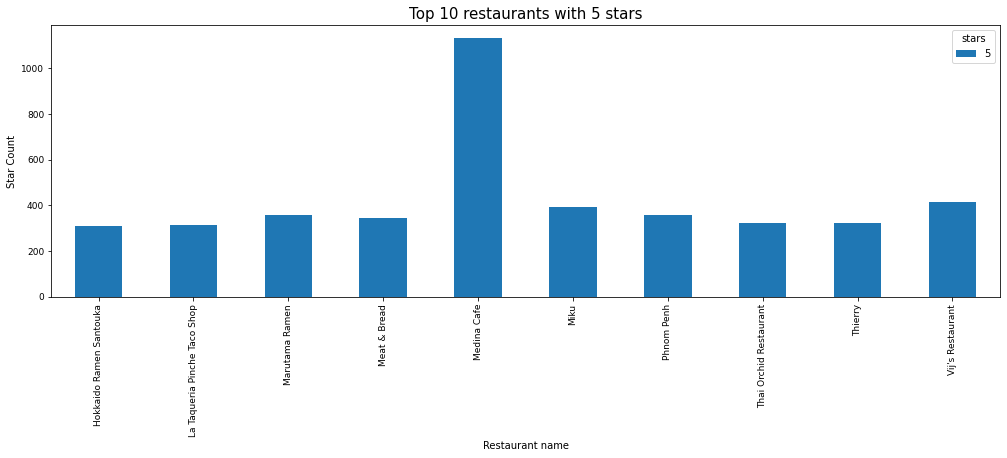

In [119]:
top_restaurant.plot.bar(figsize=(17,5))
plt.ylabel("Star Count", fontsize = 10)
plt.xlabel("Restaurant name", fontsize = 10)
plt.title("Top 10 restaurants with 5 stars", fontsize = 15)
plt.xticks(size = 9)
plt.yticks(size = 9)
plt.show()